In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("/glade/u/home/lverhoef/gdl-storm-mode/notebooks"))
from imports.GDL_layers import *

2022-08-29 10:31:09.848085: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Load data
train_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_train_data.nc")
validation_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_validation_data.nc")
test_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_test_data.nc")

In [3]:
X_train = train_ds['ellipse'].expand_dims(dim='channel', axis=-1)
X_train['p'] = np.arange(X_train['p'].shape[0])
Y_train = train_ds[['maj_len', 'min_len']].to_array().transpose()
Y_train['p'] = np.arange(Y_train['p'].shape[0])
X_val = validation_ds['ellipse'].expand_dims(dim='channel', axis=-1)
X_val['p'] = np.arange(X_val['p'].shape[0])
Y_val = validation_ds[['maj_len', 'min_len']].to_array().transpose()
Y_val['p'] = np.arange(Y_val['p'].shape[0])
X_test = test_ds['ellipse'].expand_dims(dim='channel', axis=-1)
X_test['p'] = np.arange(X_test['p'].shape[0])
Y_test = test_ds[['maj_len', 'min_len']].to_array().transpose()
Y_test['p'] = np.arange(Y_test['p'].shape[0])

In [4]:
X_train['p'].shape

(10000,)

In [4]:
def aug_da(da, concat_dim='p', rot=True):
    length = da[concat_dim].shape[0]
    aug_da = xr.concat([da]*4, dim=concat_dim)
    if rot:
        for k in range(4):
            aug_da.values[k*length:(k+1)*length] = np.rot90(aug_da.values[k*length:(k+1)*length], axes=(1, 2), k=k)
    aug_da[concat_dim] = np.arange(aug_da[concat_dim].shape[0])
    return aug_da

In [5]:
aug_X_train = aug_da(X_train)
aug_Y_train = aug_da(Y_train, rot=False)

In [6]:
# Normalize the output data
Y_scale_stats = pd.DataFrame(index=range(Y_train.shape[-1]), columns=["mean", "sd"])
Y_scale_stats.loc[:, "mean"] = Y_train.mean(dim="p")
Y_scale_stats.loc[:, "sd"] = Y_train.std(dim="p")
Y_train_norm = xr.DataArray(coords=Y_train.coords, dims=Y_train.dims)
aug_Y_train_norm = xr.DataArray(coords=aug_Y_train.coords, dims=aug_Y_train.dims)
Y_val_norm = xr.DataArray(coords=Y_val.coords, dims=Y_val.dims)
Y_test_norm = xr.DataArray(coords=Y_test.coords, dims=Y_test.dims)
for i in range(Y_train.shape[-1]):
    Y_train_norm[:, i] = (Y_train[:, i] - Y_scale_stats.loc[i, "mean"]) / Y_scale_stats.loc[i, "sd"]
    aug_Y_train_norm[:, i] = (aug_Y_train[:, i] - Y_scale_stats.loc[i, "mean"]) / Y_scale_stats.loc[i, "sd"]
    Y_val_norm[:, i] = (Y_val[:, i] - Y_scale_stats.loc[i, "mean"]) / Y_scale_stats.loc[i, "sd"]
    Y_test_norm[:, i] = (Y_test[:, i] - Y_scale_stats.loc[i, "mean"]) / Y_scale_stats.loc[i, "sd"]

In [8]:
ricnn_model = models.Sequential()
ricnn_model.add(RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(128, 128, 1)))
ricnn_model.add(RotEquivPool2D((2, 2)))
ricnn_model.add(RotEquivConv2D(32, (3, 3)))
ricnn_model.add(RotEquivPool2D((2, 2)))
ricnn_model.add(RotEquivConv2D(64, (3, 3)))
ricnn_model.add(RotEquivPool2D((2, 2)))
ricnn_model.add(RotEquivConv2D(64, (3, 3)))
ricnn_model.add(RotEquivPool2D((2, 2)))
ricnn_model.add(RotEquivConv2D(128, (3, 3)))
ricnn_model.add(layers.MaxPool3D((1, 1, 4)))
# ricnn_model.add(RotInvPool())
ricnn_model.add(layers.Flatten())
ricnn_model.add(layers.Dense(32))
ricnn_model.add(layers.Dense(2))

2022-08-28 14:05:28.382418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-28 14:05:31.334843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


In [9]:
ricnn_model.compile(
    optimizer='adam',
    loss='mse',
)

In [10]:
ricnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 126, 126, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 63, 63, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_equiv_conv2d_1 (RotEqui  (None, 61, 61, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 30, 30, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 28, 28, 4, 64)    1

In [11]:
ricnn_history = ricnn_model.fit(
    x=X_train, y=Y_train_norm,
    epochs=10, validation_data=(X_val, Y_val_norm),
    shuffle=True
)

Epoch 1/10


2022-08-28 14:05:40.325359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


313/313 [==============================] - 36s 63ms/step - loss: 0.3707 - val_loss: 0.1554
Epoch 2/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0764 - val_loss: 0.0363
Epoch 3/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0244 - val_loss: 0.0214
Epoch 4/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0191 - val_loss: 0.0122
Epoch 5/10
313/313 [==============================] - 18s 59ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 6/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0140 - val_loss: 0.0084
Epoch 7/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0135 - val_loss: 0.0171
Epoch 8/10
313/313 [==============================] - 18s 57ms/step - loss: 0.0129 - val_loss: 0.0071
Epoch 9/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0115 - val_loss: 0.0080
Epoch 10/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0111 - val_los

<xarray.Dataset>
Dimensions:  (p: 10)
Dimensions without coordinates: p
Data variables:
    maj_len  (p) float64 26.64 12.29 21.85 22.32 25.26 ... 21.0 36.23 38.3 28.21
    min_len  (p) float64 17.37 7.178 14.07 1.839 ... 12.29 16.74 17.86 8.65

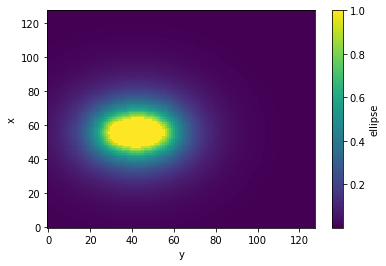

In [9]:
validation_ds['ellipse'][0, :, :].plot()
validation_ds[['maj_len', 'min_len']].sel(p=slice(0, 10))

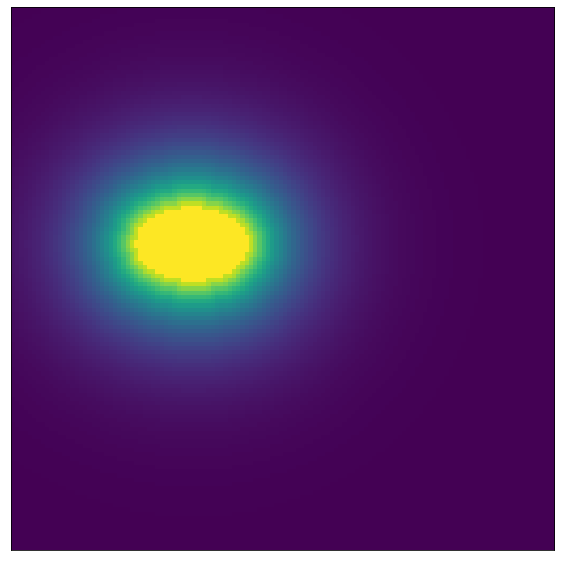

In [27]:
F, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(validation_ds['ellipse'][0, :, :], cmap='viridis')
ax.set_xticks([])
ax.set_yticks([])
F.set_facecolor('white')

In [12]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(2))

In [13]:
cnn_model.compile(
    optimizer='adam',
    loss='mse',
)

In [14]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)      

In [15]:
cnn_history = cnn_model.fit(
    x=X_train, y=Y_train_norm,
    epochs=10, validation_data=(X_val, Y_val_norm),
    shuffle=True
)

Epoch 1/10
313/313 [==============================] - 5s 14ms/step - loss: 0.4588 - val_loss: 0.2543
Epoch 2/10
313/313 [==============================] - 5s 16ms/step - loss: 0.1838 - val_loss: 0.0806
Epoch 3/10
313/313 [==============================] - 5s 17ms/step - loss: 0.0691 - val_loss: 0.0591
Epoch 4/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0401 - val_loss: 0.0288
Epoch 5/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0306 - val_loss: 0.0300
Epoch 6/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0236 - val_loss: 0.0172
Epoch 7/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0187 - val_loss: 0.0152
Epoch 8/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0175 - val_loss: 0.0141
Epoch 9/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0164 - val_loss: 0.0143
Epoch 10/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0162 - val_lo

In [16]:
aug_cnn_model = models.Sequential()
aug_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
aug_cnn_model.add(layers.MaxPooling2D((2, 2)))
aug_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
aug_cnn_model.add(layers.MaxPooling2D((2, 2)))
aug_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
aug_cnn_model.add(layers.MaxPooling2D((2, 2)))
aug_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
aug_cnn_model.add(layers.MaxPooling2D((2, 2)))
aug_cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_cnn_model.add(layers.Flatten())
aug_cnn_model.add(layers.Dense(32, activation='relu'))
aug_cnn_model.add(layers.Dense(2))

In [17]:
aug_cnn_model.compile(
    optimizer='adam',
    loss='mse',
)

In [18]:
aug_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 64)      

In [19]:
aug_cnn_history = aug_cnn_model.fit(
    x=aug_X_train, y=aug_Y_train_norm,
    epochs=10, validation_data=(X_val, Y_val_norm),
    shuffle=True
)

Epoch 1/10
1250/1250 [==============================] - 16s 12ms/step - loss: 0.2388 - val_loss: 0.0344
Epoch 2/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.0268 - val_loss: 0.0117
Epoch 3/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0182 - val_loss: 0.0128
Epoch 4/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0144 - val_loss: 0.0094
Epoch 5/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 6/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.0109 - val_loss: 0.0078
Epoch 7/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.0102 - val_loss: 0.0071
Epoch 8/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 9/10
1250/1250 [==============================] - 16s 12ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 10/10
1250/1250 [==============================] - 16s 12m

Text(0, 0.5, 'MSE')

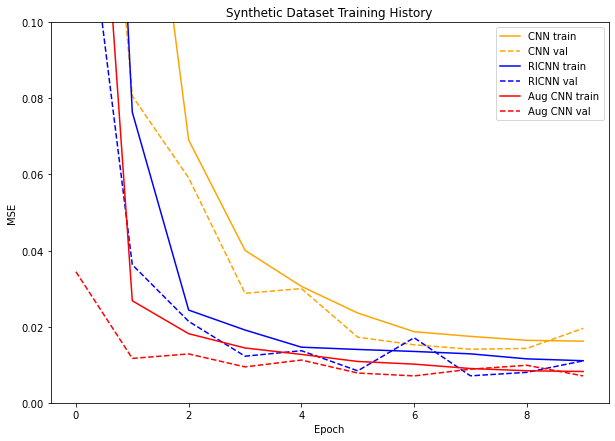

In [29]:
F, ax = plt.subplots(1, 1, figsize=(10, 7))
ax = plt.gca()
a = ax.plot(cnn_history.history['loss'], label='CNN train', color='orange')
b = ax.plot(cnn_history.history['val_loss'], label='CNN val', color='orange', linestyle='dashed')
c = ax.plot(ricnn_history.history['loss'], label='RICNN train', color='blue')
d = ax.plot(ricnn_history.history['val_loss'], label='RICNN val', color='blue', linestyle='dashed')
e = ax.plot(aug_cnn_history.history['loss'], label='Aug CNN train', color='red')
f = ax.plot(aug_cnn_history.history['val_loss'], label='Aug CNN val', color='red', linestyle='dashed')
ax.legend()
F.set_facecolor('white')
ax.set_title("Synthetic Dataset Training History")
ax.set_ylim(bottom=0, top=0.10)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')

In [62]:
ricnn_model.save("saved_models/toy_ds_aug/ricnn_model")
cnn_model.save("saved_models/toy_ds_aug/cnn_model")
aug_cnn_model.save("saved_models/toy_ds_aug/aug_cnn_model")

INFO:tensorflow:Assets written to: saved_models/toy_ds_aug/ricnn_model/assets


INFO:tensorflow:Assets written to: saved_models/toy_ds_aug/cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/toy_ds_aug/cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/toy_ds_aug/aug_cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/toy_ds_aug/aug_cnn_model/assets


In [10]:
ricnn_model = tf.keras.models.load_model("saved_models/toy_ds_aug/ricnn_model")
cnn_model = tf.keras.models.load_model("saved_models/toy_ds_aug/cnn_model")
aug_cnn_model = tf.keras.models.load_model("saved_models/toy_ds_aug/aug_cnn_model")

In [30]:
ricnn_model.evaluate(X_val, Y_val_norm)
ricnn_model.evaluate(X_test, Y_test_norm)

32/32 [==============================] - 1s 22ms/step - loss: 0.0141


0.014057747088372707

In [31]:
cnn_model.evaluate(X_val, Y_val_norm)
cnn_model.evaluate(X_test, Y_test_norm)

32/32 [==============================] - 0s 7ms/step - loss: 0.7100


0.709987998008728

In [32]:
aug_cnn_model.evaluate(X_val, Y_val_norm)
aug_cnn_model.evaluate(X_test, Y_test_norm)

32/32 [==============================] - 0s 8ms/step - loss: 0.0075


0.007536854594945908

In [7]:
Y_test_norm[0:1]

<xarray.DataArray (p: 1, variable: 2)>
array([[-0.85937059, -0.07984741]])
Coordinates:
  * variable  (variable) <U7 'maj_len' 'min_len'
  * p         (p) int64 0

In [8]:
aug_X_test = aug_da(X_test)

In [69]:
aug_cnn_model(aug_X_test[0:1].values)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.9147026 , -0.05177283]], dtype=float32)>

In [71]:
aug_cnn_model(aug_X_test[1000:1001].values)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.8761267 , -0.15146962]], dtype=float32)>

In [74]:
ricnn_model(aug_X_test[0:1].values)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.88812345, -0.03368896]], dtype=float32)>

In [75]:
ricnn_model(aug_X_test[1000:1001].values)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.88812333, -0.03368849]], dtype=float32)>

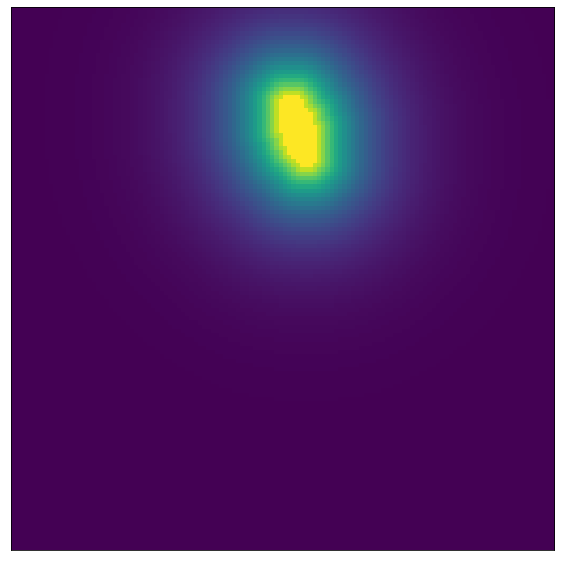

In [9]:
F, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(aug_X_test[0, :, :, 0], cmap='viridis')
ax.set_xticks([])
ax.set_yticks([])
F.set_facecolor('white')

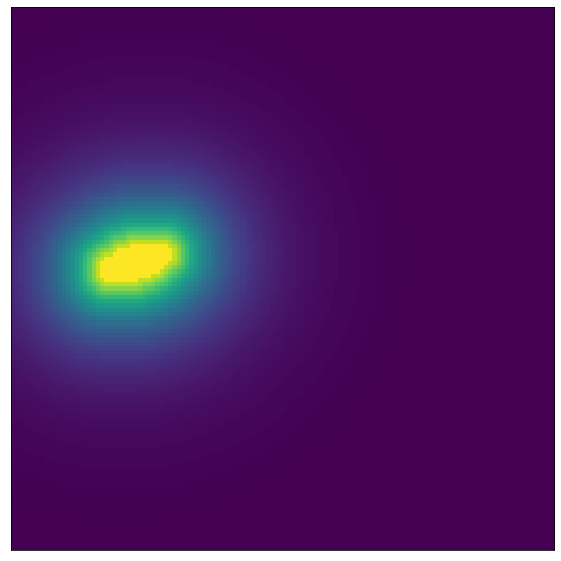

In [10]:
F, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(aug_X_test[1000, :, :, 0], cmap='viridis')
ax.set_xticks([])
ax.set_yticks([])
F.set_facecolor('white')